In [1]:
import numpy as np
import cvxpy as cvx

from pympc.geometry.polytope import Polytope
from pympc.optimization.gurobi import linear_program

import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

In [2]:
def maximum_volume_inscribed_ellipsoid(A, b):
    C = cvx.Variable(n_var, n_var)
    d = cvx.Variable(n_var)
    objective = cvx.Maximize(cvx.log_det(C))
    constraints = [cvx.norm(C*A[i,:]) + A[i,:].T*d <= b[i,0] for i in range(A.shape[0])]
    prob = cvx.Problem(objective, constraints)
    result = prob.solve()
    C = np.array(C.value)
    d = np.array(d.value)
    return C, d

In [3]:
def outer_box_aligned_with_ellipsoid(A, b, C, d):
    T = np.linalg.eig(C)[1]
    A_new = A.dot(T)
    box_min = np.zeros((A.shape[1], 1))
    box_max = np.zeros((A.shape[1], 1))
    for i in range(A.shape[1]):
        f = np.zeros((A.shape[1], 1))
        f[i,0] = 1.
        sol_min = linear_program(f, A_new, b)
        sol_max = linear_program(-f, A_new, b)
        box_min[i,0] = sol_min.min
        box_max[i,0] = -sol_max.min
    box = Polytope.from_bounds(box_min, box_max)
    A_box = box.A.dot(np.linalg.inv(T))
    b_box = box.b
    return A_box, b_box

In [4]:
def draw_2d_ellipe(C, d, **kwargs):
    eigenvalues, eigenvectors = np.linalg.eig(C)
    width = eigenvalues[0]*2.
    height = eigenvalues[1]*2.
    angle = np.arctan2(eigenvectors[1,0],eigenvectors[0,0])*180./np.pi
    ell = Ellipse(xy=d, width=width, height=height, angle=angle, **kwargs)
    ax = plt.gca()
    ax.add_artist(ell)
    ax.autoscale_view()
    return

In [5]:
n_var = 2
n_cons = 10
A = np.random.randn(n_cons, n_var)
b = np.random.rand(n_cons, 1)
C, d = maximum_volume_inscribed_ellipsoid(A, b)
A_box, b_box = outer_box_aligned_with_ellipsoid(A, b, C, d)

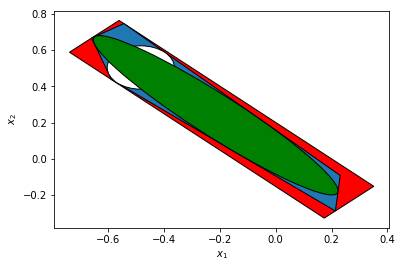

In [6]:
box = Polytope(A_box, b_box)
box.assemble()
box.plot(facecolor='red')
p = Polytope(A, b)
p.assemble()
p.plot(largest_ball=True)
draw_2d_ellipe(C, d, facecolor='green', edgecolor='black')
plt.show()